<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Creating-a-cluster-data-generator" data-toc-modified-id="Creating-a-cluster-data-generator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Creating a cluster data generator</a></span></li><li><span><a href="#Paramatizable-MLP" data-toc-modified-id="Paramatizable-MLP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Paramatizable MLP</a></span></li><li><span><a href="#Experiments-with-number-of-layers" data-toc-modified-id="Experiments-with-number-of-layers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experiments with number of layers</a></span></li></ul></div>

# Creating a cluster data generator

Here we create a class that generates training data which comes from a specified number of clusters.

In [1]:
import numpy as np

class cluster_data_generator:

    def __init__(self):
        
        print("new cluster data generator "
              "object created.")
        
    def generate_data(self, nr_clusters, nr_samples):
        
        #np.random.seed(140376)
        CLUSTER_RADIUS = 0.3

        # 1. generate random cluster coordinates
        clusters = []
        for i in range(nr_clusters):

            # 1.1 generate random cluster center
            P = np.random.uniform(low=-1.0,
                                  high=+1.0,
                                  size=(2,))                                         
            
            # 1.2 store that cluster center
            clusters.append( P )


        # 2. generate random samples
        X = np.zeros( (nr_samples, 2) )
        Y = np.zeros( (nr_samples,) )
        for i in range(nr_samples):

            # 2.1 generate random point            
            P = np.random.uniform(low=-1.0,
                                  high=+1.0,
                                  size=(2,))                                         
            
            # 2.2 check whether that coordinate is
            #     near to a cluster
            #     if yes, we say it belongs to class 1
            #     if no,  we say it belongs to class 0
            class_label = 0
            for j in range(nr_clusters):

                # get cluster coordinates
                cluster_coords = clusters[j]

                # compute distance of sample P to
                # cluster coordinates
                dist = np.linalg.norm( cluster_coords - P )

                # is the sample near to that cluster
                if dist < CLUSTER_RADIUS:
                    class_label = 1
                    break

            # 2.3 store the sample
            X[i,:] = P
            Y[i] = class_label
            
        # 4. return the generated sample input vecs X
        #    and output vecs Y
        return X,Y

Now let us test whether the cluster data generator works:

new cluster data generator object created.


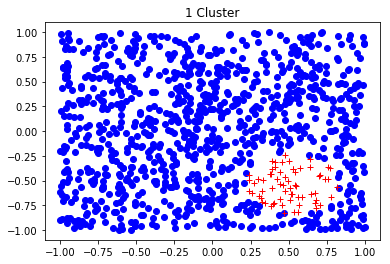

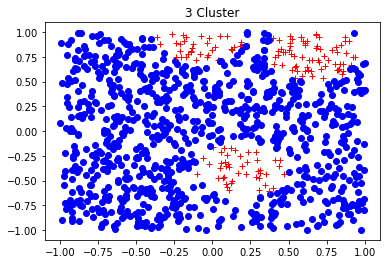

In [3]:
import matplotlib.pyplot as plt

def plot_data(title_text, X,Y):
        
    nr_samples = X.shape[0]
    for i in range(0,nr_samples):
        if Y[i] == 1:
            plt.plot(X[i,0], X[i,1], 'r+')
        else:
            plt.plot(X[i,0], X[i,1], 'bo')
            
    plt.title( title_text )
    plt.show()

dg = cluster_data_generator()

X,Y = dg.generate_data(1,1000)
plot_data("1 Cluster", X,Y)

X,Y = dg.generate_data(3,1000)
plot_data("3 Cluster", X,Y)

# Paramatizable MLP

Now we build up code that allows us to generate MLPs with a varying number of layers and neurons per layer.

In [4]:
from keras.models import Sequential
from keras import layers
from keras.layers.core import Dense
from keras import backend as K
    
def create_model(nr_layers, nr_neurons_per_layer):
    
    K.clear_session()
        
    model = Sequential()
    
    for i in range(0,nr_layers):
        model.add(Dense(nr_neurons_per_layer,
                        activation="relu",
                        input_dim=2))
    model.add(Dense(1))
    
    return model
    

def train_model(model, X,Y):
    
    model.compile(loss='mean_squared_error', optimizer='sgd')
    history = model.fit(X,Y, epochs=2000, verbose=0)
    
    return history

    
def test_model(model, X,Y):

    nr_samples = X.shape[0]
    
    correct_classified = 0
    predicted_Y = np.zeros( (nr_samples,) )
    
    for i in range(0,nr_samples):
        
        # get next sample coordinates        
        P = X[i]
        P = P.reshape((-1,2))
        
        # get desired output
        gt_class = Y[i]
        
        #print(P)
        #print(gt)
        
        output_values = model.predict(P)
        if output_values[0][0] > 0.5:
            predicted_class = 1
        else:
            predicted_class = 0
            
        if predicted_class==gt_class:
            correct_classified +=1
            
        predicted_Y[i] = predicted_class
        
        
    print("Correct classified: {} of {}".
         format(correct_classified, nr_samples ))
    
    correct_rate = \
        float(correct_classified)/float(nr_samples)
    
    return correct_rate, predicted_Y


def experiment(nr_clusters):

    # 1. Generate training data
    X,Y = dg.generate_data(nr_clusters,1000)
    plot_data("Training data, {} cluster(s)".
              format(nr_clusters), X,Y)

    # 2. Test different MLP models
    list_nr_layers = []
    list_corr_rates = []
    for nr_layers in range(0, 11):

        print("\n\n")
        print("=====================================")
        print("Experiment with a MLP with {} layers"
              " for a training data set with {} clusters".
              format(nr_layers, nr_clusters))
        print("=====================================")


        # 2.1 Create MLP model with specified
        #     number of neurons
        nr_neurons_per_layer = 5    
        model = create_model(nr_layers, nr_neurons_per_layer)
        #model.summary()


        # 2.2 Train the model
        print("Training model with {} layers and "
              "{} neurons per layer...".
             format(nr_layers, nr_neurons_per_layer))
        history = train_model( model, X,Y )
        #print(history.history.keys())
        plt.plot(history.history["loss"])
        plt.title("Training loss as a function of epoch nr")
        plt.show()


        # 2.3 Test the model
        correct_rate, predicted_Y = test_model( model,X,Y )


        # 2.4 Show test results
        plot_data("Test results: L{} N{} -> {:6.2f}% correct".
                  format(nr_layers,
                         nr_neurons_per_layer,
                         correct_rate*100.0),
                  X, predicted_Y)


        # 2.5 Save test results for later
        #     plotting of a comparison between
        #     the different models
        list_nr_layers.append(nr_layers)
        list_corr_rates.append(correct_rate*100.0) 

        
    # 3. Show comparison of different models
    plt.xticks(list_nr_layers)
    plt.bar(list_nr_layers, list_corr_rates)
    plt.title("Comparison of trained models for {} clusters".
             format(nr_clusters))
    plt.xlabel("Model nr")
    plt.ylabel("Correct classifcation rate")
    plt.show()


Using TensorFlow backend.


# Experiments with number of layers

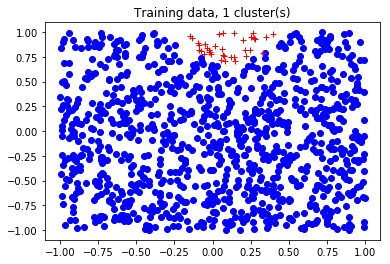




Experiment with a MLP with 0 layers for a training data set with 1 clusters
Training model with 0 layers and 5 neurons per layer...


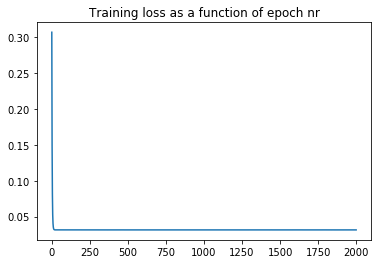

Correct classified: 964 of 1000


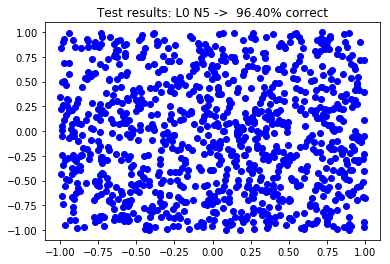




Experiment with a MLP with 1 layers for a training data set with 1 clusters
Training model with 1 layers and 5 neurons per layer...


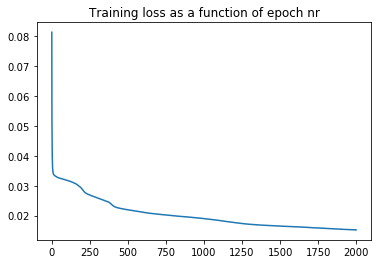

Correct classified: 987 of 1000


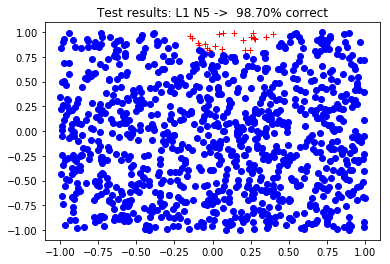




Experiment with a MLP with 2 layers for a training data set with 1 clusters
Training model with 2 layers and 5 neurons per layer...


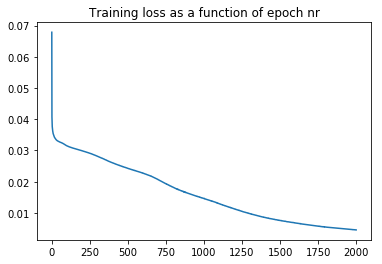

Correct classified: 999 of 1000


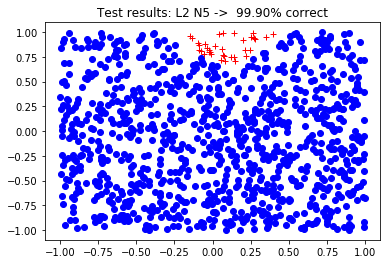




Experiment with a MLP with 3 layers for a training data set with 1 clusters
Training model with 3 layers and 5 neurons per layer...


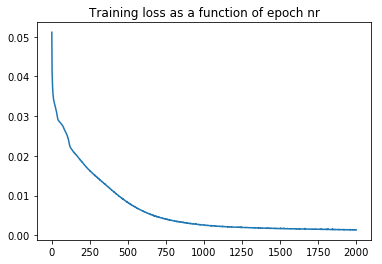

Correct classified: 999 of 1000


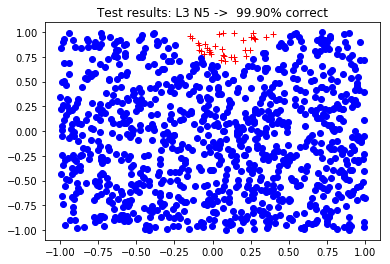




Experiment with a MLP with 4 layers for a training data set with 1 clusters
Training model with 4 layers and 5 neurons per layer...


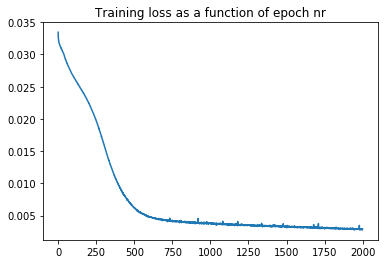

Correct classified: 999 of 1000


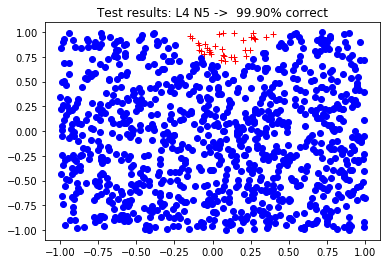




Experiment with a MLP with 5 layers for a training data set with 1 clusters
Training model with 5 layers and 5 neurons per layer...


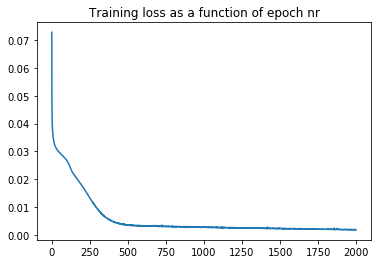

Correct classified: 999 of 1000


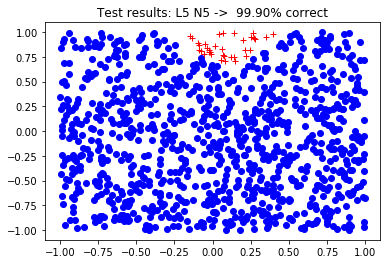




Experiment with a MLP with 6 layers for a training data set with 1 clusters
Training model with 6 layers and 5 neurons per layer...


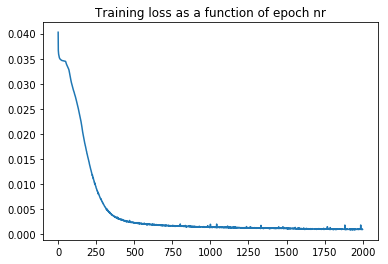

Correct classified: 999 of 1000


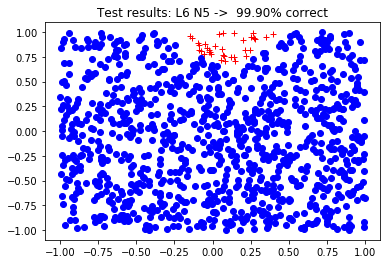




Experiment with a MLP with 7 layers for a training data set with 1 clusters
Training model with 7 layers and 5 neurons per layer...


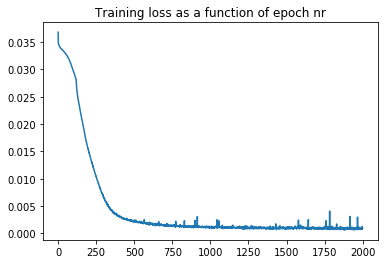

Correct classified: 999 of 1000


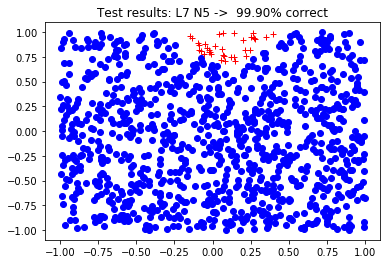




Experiment with a MLP with 8 layers for a training data set with 1 clusters
Training model with 8 layers and 5 neurons per layer...


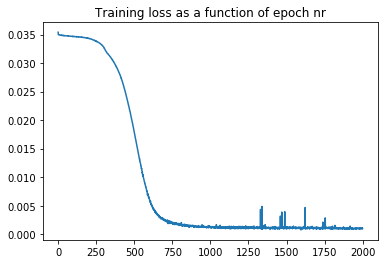

Correct classified: 999 of 1000


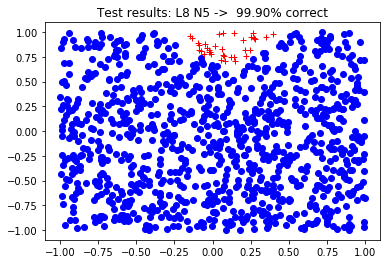




Experiment with a MLP with 9 layers for a training data set with 1 clusters
Training model with 9 layers and 5 neurons per layer...


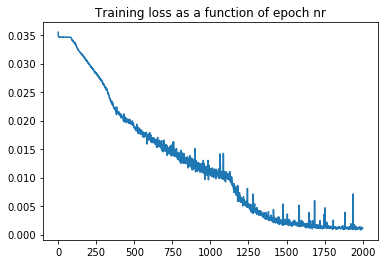

Correct classified: 999 of 1000


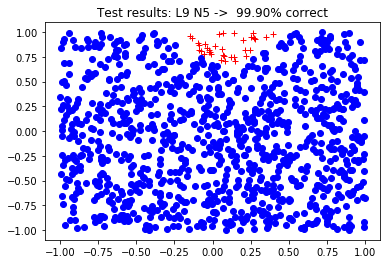




Experiment with a MLP with 10 layers for a training data set with 1 clusters
Training model with 10 layers and 5 neurons per layer...


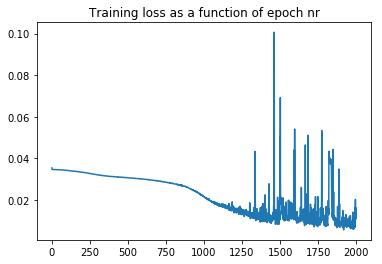

Correct classified: 985 of 1000


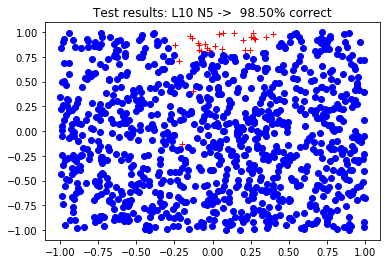

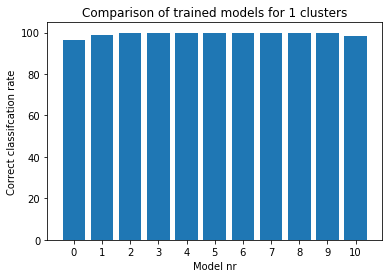

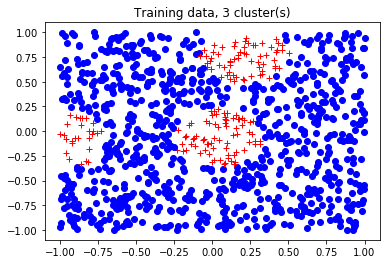




Experiment with a MLP with 0 layers for a training data set with 3 clusters
Training model with 0 layers and 5 neurons per layer...


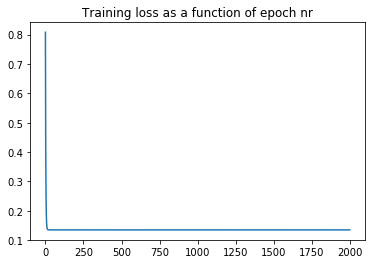

Correct classified: 830 of 1000


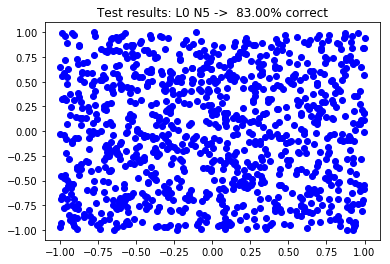




Experiment with a MLP with 1 layers for a training data set with 3 clusters
Training model with 1 layers and 5 neurons per layer...


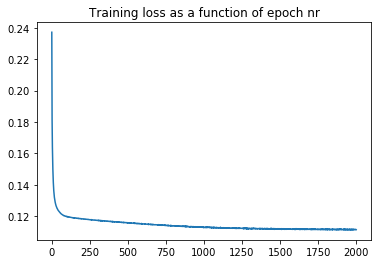

Correct classified: 826 of 1000


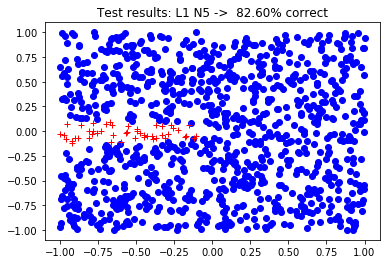




Experiment with a MLP with 2 layers for a training data set with 3 clusters
Training model with 2 layers and 5 neurons per layer...


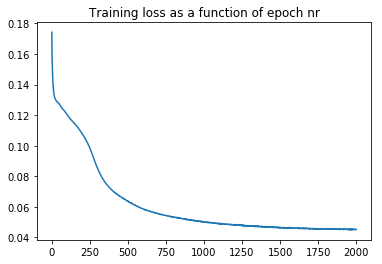

Correct classified: 955 of 1000


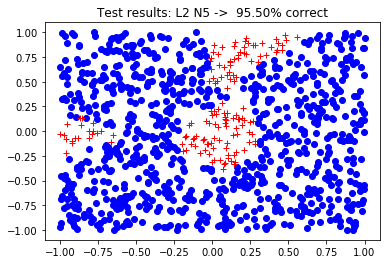




Experiment with a MLP with 3 layers for a training data set with 3 clusters
Training model with 3 layers and 5 neurons per layer...


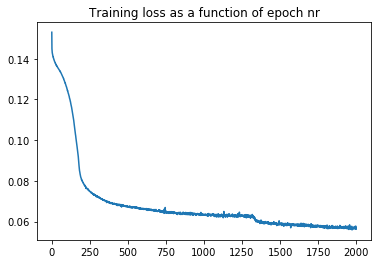

Correct classified: 924 of 1000


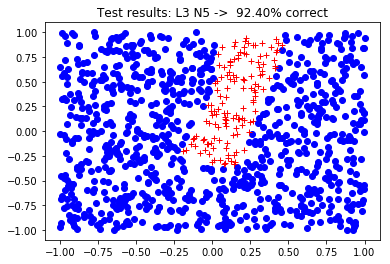




Experiment with a MLP with 4 layers for a training data set with 3 clusters
Training model with 4 layers and 5 neurons per layer...


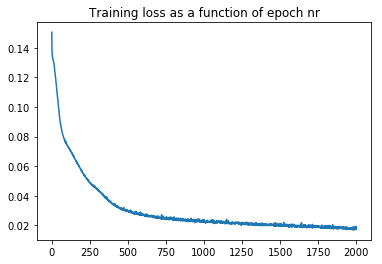

Correct classified: 988 of 1000


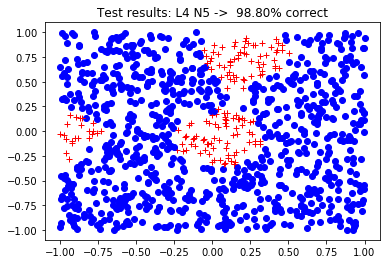




Experiment with a MLP with 5 layers for a training data set with 3 clusters
Training model with 5 layers and 5 neurons per layer...


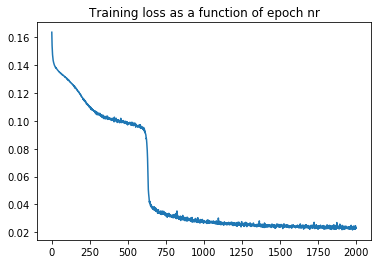

Correct classified: 975 of 1000


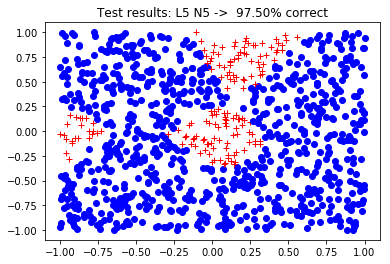




Experiment with a MLP with 6 layers for a training data set with 3 clusters
Training model with 6 layers and 5 neurons per layer...


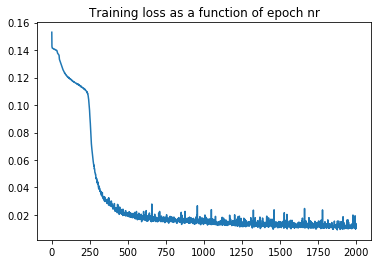

Correct classified: 982 of 1000


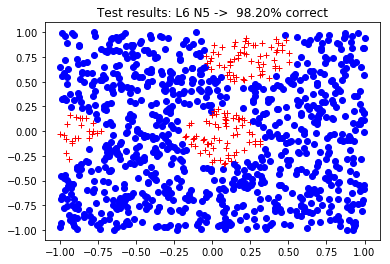




Experiment with a MLP with 7 layers for a training data set with 3 clusters
Training model with 7 layers and 5 neurons per layer...


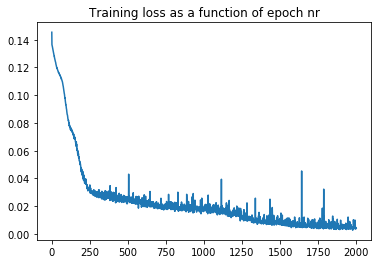

Correct classified: 989 of 1000


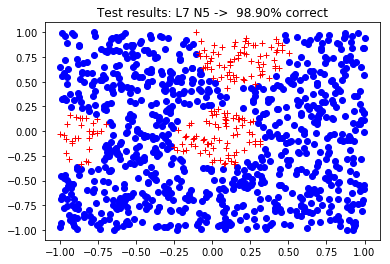




Experiment with a MLP with 8 layers for a training data set with 3 clusters
Training model with 8 layers and 5 neurons per layer...


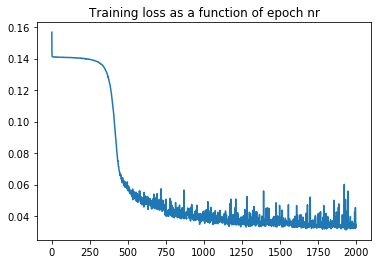

Correct classified: 968 of 1000


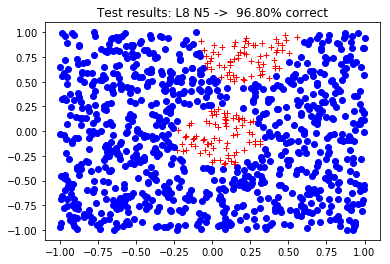




Experiment with a MLP with 9 layers for a training data set with 3 clusters
Training model with 9 layers and 5 neurons per layer...


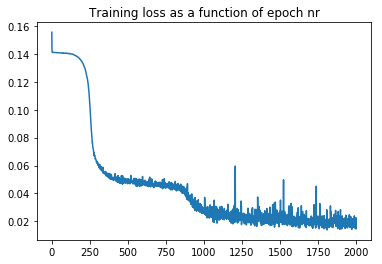

Correct classified: 984 of 1000


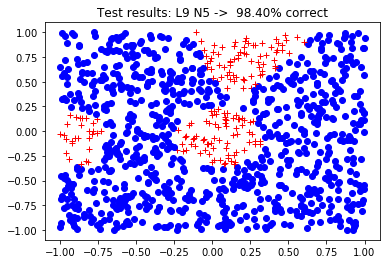




Experiment with a MLP with 10 layers for a training data set with 3 clusters
Training model with 10 layers and 5 neurons per layer...


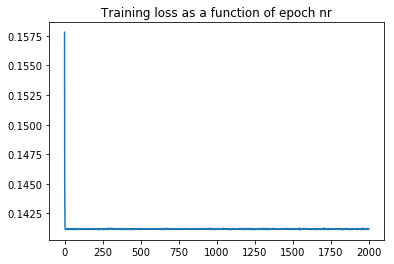

Correct classified: 830 of 1000


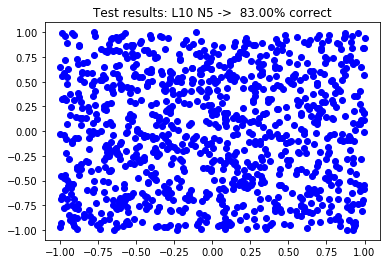

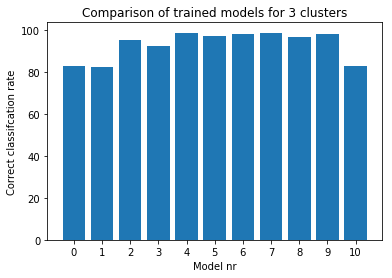

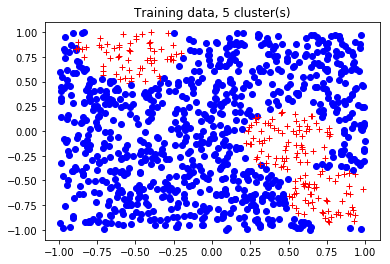




Experiment with a MLP with 0 layers for a training data set with 5 clusters
Training model with 0 layers and 5 neurons per layer...


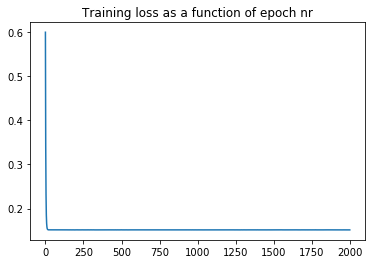

Correct classified: 804 of 1000


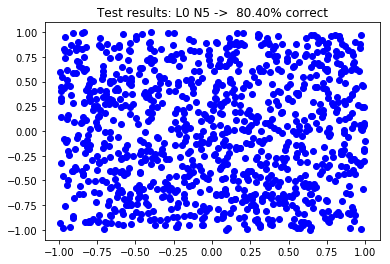




Experiment with a MLP with 1 layers for a training data set with 5 clusters
Training model with 1 layers and 5 neurons per layer...


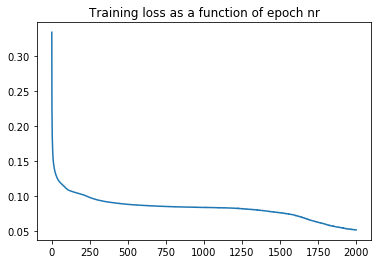

Correct classified: 935 of 1000


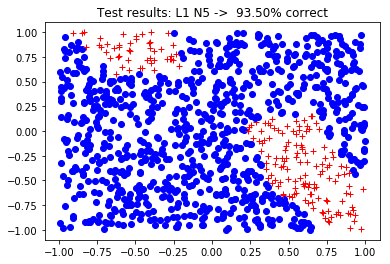




Experiment with a MLP with 2 layers for a training data set with 5 clusters
Training model with 2 layers and 5 neurons per layer...


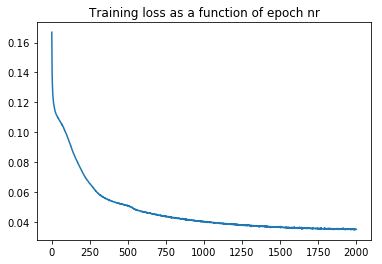

Correct classified: 955 of 1000


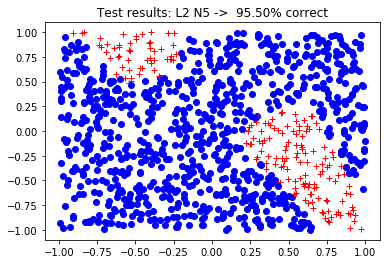




Experiment with a MLP with 3 layers for a training data set with 5 clusters
Training model with 3 layers and 5 neurons per layer...


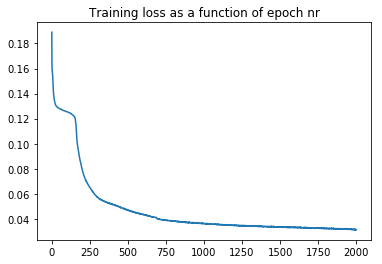

Correct classified: 968 of 1000


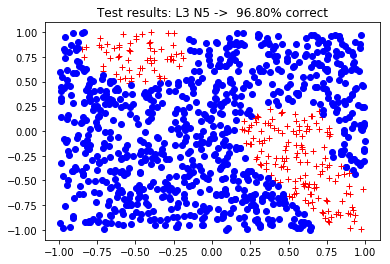




Experiment with a MLP with 4 layers for a training data set with 5 clusters
Training model with 4 layers and 5 neurons per layer...


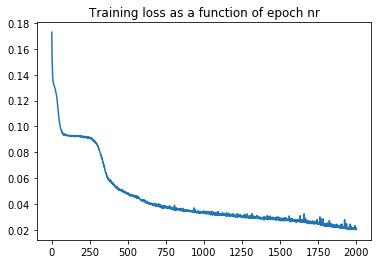

Correct classified: 972 of 1000


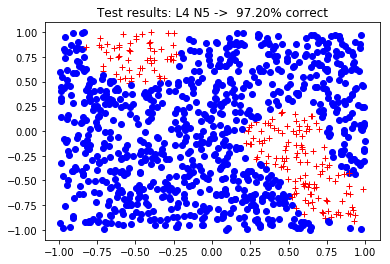




Experiment with a MLP with 5 layers for a training data set with 5 clusters
Training model with 5 layers and 5 neurons per layer...


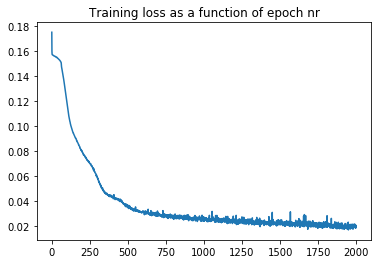

Correct classified: 974 of 1000


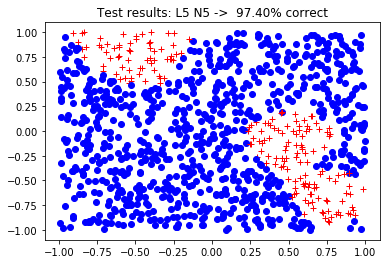




Experiment with a MLP with 6 layers for a training data set with 5 clusters
Training model with 6 layers and 5 neurons per layer...


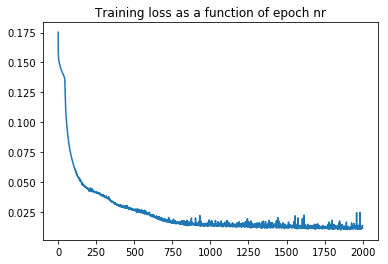

Correct classified: 989 of 1000


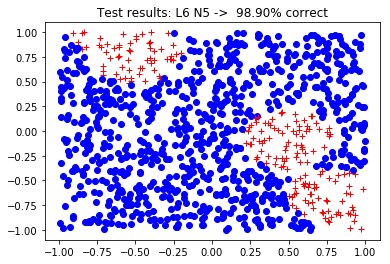




Experiment with a MLP with 7 layers for a training data set with 5 clusters
Training model with 7 layers and 5 neurons per layer...


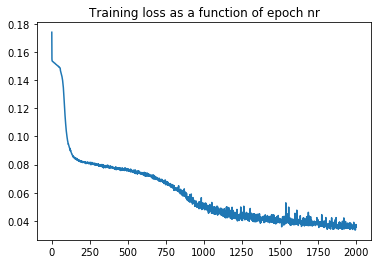

Correct classified: 938 of 1000


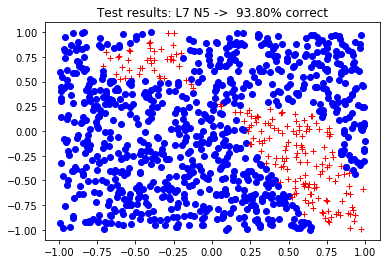




Experiment with a MLP with 8 layers for a training data set with 5 clusters
Training model with 8 layers and 5 neurons per layer...


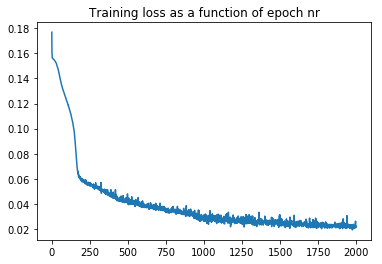

Correct classified: 942 of 1000


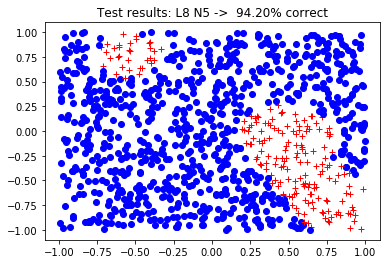




Experiment with a MLP with 9 layers for a training data set with 5 clusters
Training model with 9 layers and 5 neurons per layer...


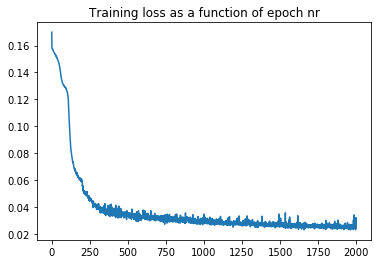

Correct classified: 973 of 1000


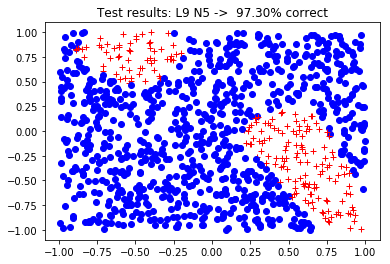




Experiment with a MLP with 10 layers for a training data set with 5 clusters
Training model with 10 layers and 5 neurons per layer...


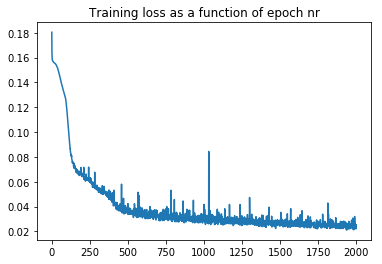

Correct classified: 958 of 1000


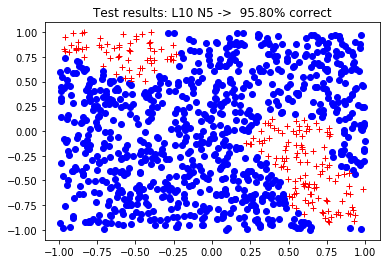

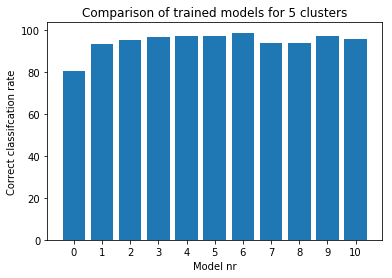

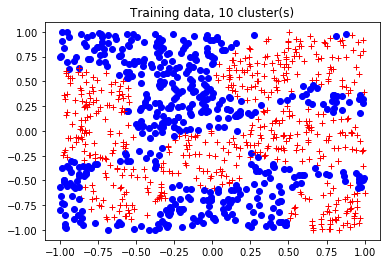




Experiment with a MLP with 0 layers for a training data set with 10 clusters
Training model with 0 layers and 5 neurons per layer...


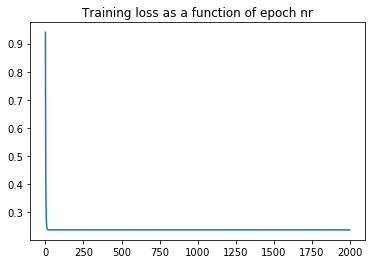

Correct classified: 606 of 1000


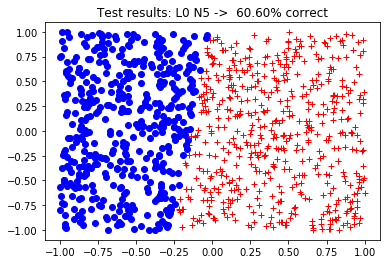




Experiment with a MLP with 1 layers for a training data set with 10 clusters
Training model with 1 layers and 5 neurons per layer...


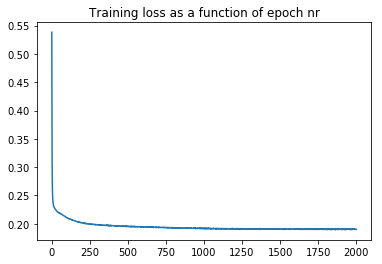

Correct classified: 733 of 1000


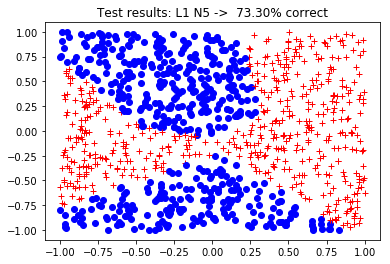




Experiment with a MLP with 2 layers for a training data set with 10 clusters
Training model with 2 layers and 5 neurons per layer...


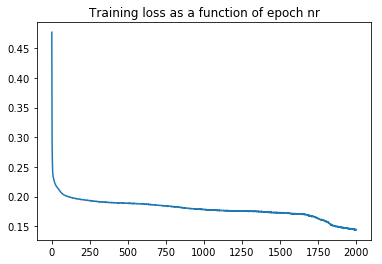

Correct classified: 781 of 1000


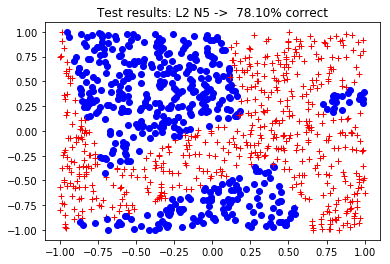




Experiment with a MLP with 3 layers for a training data set with 10 clusters
Training model with 3 layers and 5 neurons per layer...


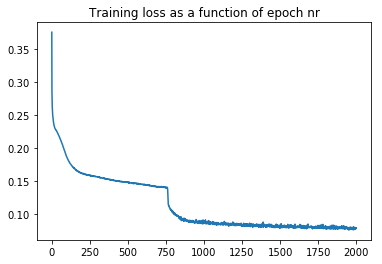

Correct classified: 896 of 1000


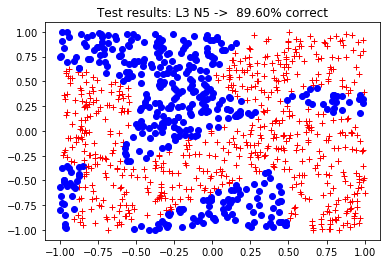




Experiment with a MLP with 4 layers for a training data set with 10 clusters
Training model with 4 layers and 5 neurons per layer...


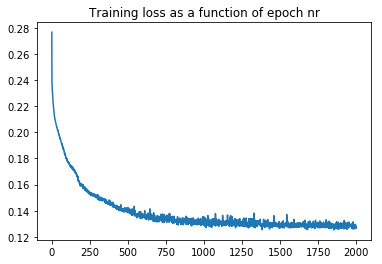

Correct classified: 825 of 1000


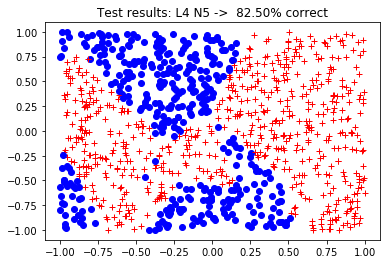




Experiment with a MLP with 5 layers for a training data set with 10 clusters
Training model with 5 layers and 5 neurons per layer...


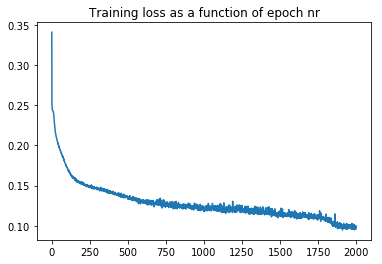

Correct classified: 880 of 1000


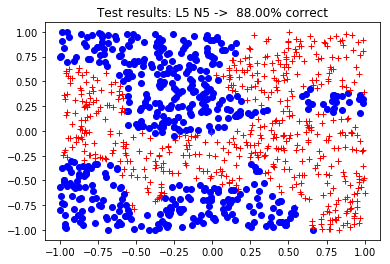




Experiment with a MLP with 6 layers for a training data set with 10 clusters
Training model with 6 layers and 5 neurons per layer...


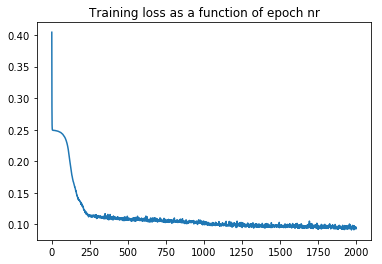

Correct classified: 855 of 1000


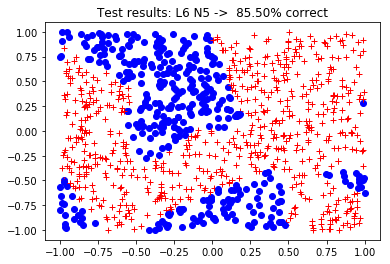




Experiment with a MLP with 7 layers for a training data set with 10 clusters
Training model with 7 layers and 5 neurons per layer...


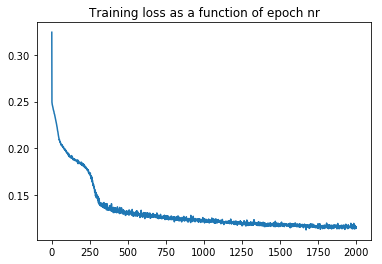

Correct classified: 837 of 1000


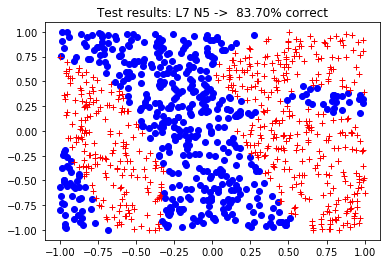




Experiment with a MLP with 8 layers for a training data set with 10 clusters
Training model with 8 layers and 5 neurons per layer...


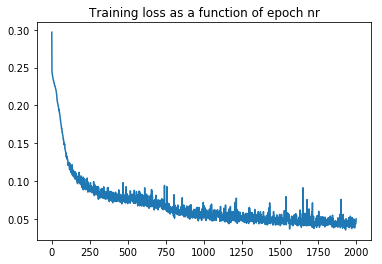

Correct classified: 919 of 1000


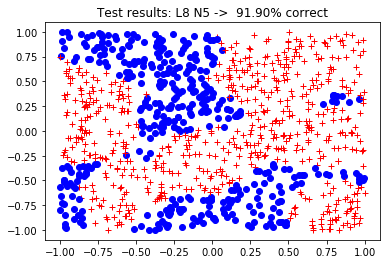




Experiment with a MLP with 9 layers for a training data set with 10 clusters
Training model with 9 layers and 5 neurons per layer...


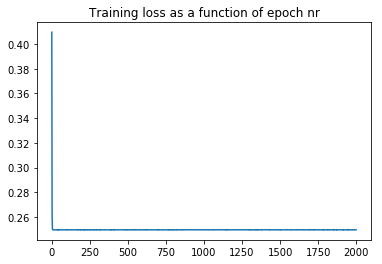

Correct classified: 524 of 1000


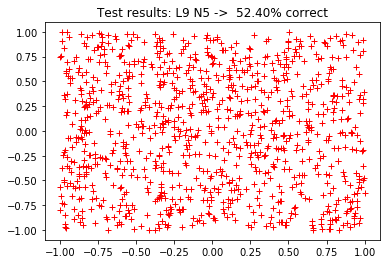




Experiment with a MLP with 10 layers for a training data set with 10 clusters
Training model with 10 layers and 5 neurons per layer...


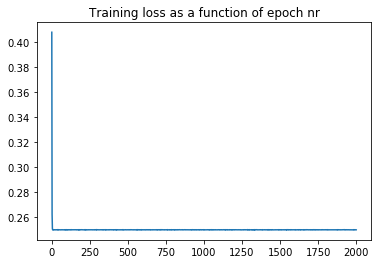

Correct classified: 524 of 1000


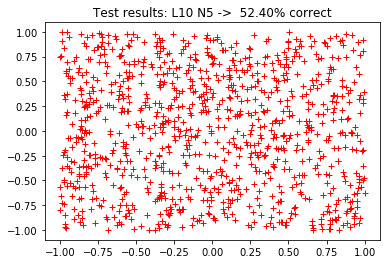

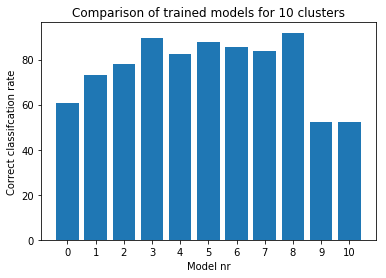

In [92]:
experiment(1)
experiment(3)
experiment(5)
experiment(10)